HighTime - Web traffic analysis neural model
=============
<span style="color: lightsteelblue;">Deep Learning</span>

The goal of this assignment is to train a simple DNN model to make predictions over web traffic.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import os
import numpy as np
import random
import string
import tensorflow as tf
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve
import matplotlib.pyplot as plt

Let us mimic real traffic data by using normal distribution:

[ 13  15  27  44  83 127 195 262 345 423 476 480 489 430 416 359 291 189]


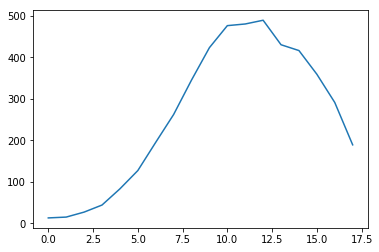

In [2]:
def fake_train(batch_size=24):
  assert batch_size > 0 and batch_size < 25
  normal = np.random.normal(12, 4, 5000)
  train = np.arange(batch_size)

  for i in range(0, batch_size):
    count = 0
    for p in normal:
      if (p >= i and p < i + 1):
        count += 1
    train[i] = count
  return train

example = fake_train(18)
print(example)

plt.plot(range(0, 18), example)
plt.show()

Function to generate a training batch:

In [29]:
total_seconds = 24 * 3600
total_rps = 1000

def secs_to_time(time_in_seconds):
  hours = time_in_seconds // 3600
  minutes = (time_in_seconds - hours * 3600) // 60
  seconds = time_in_seconds - hours * 3600 - minutes * 60
  return hours, minutes, seconds

def time_to_secs(hour, minutes, seconds):
  return hour * 3600 + minutes * 60 + seconds

def time_to_squashed_secs(hour, minutes, seconds):
  return time_to_secs(hour, minutes, seconds) / total_seconds

def secs_to_string(sec):
  result = ':'.join([('%d' % i) for i in secs_to_time(sec)])
  return result + (' (%dth second)' % sec)

def squashed_secs_to_string(sq_sec):
  return secs_to_string(sq_sec * total_seconds)

def squashed_label_to_label(sq_label):
  return sq_label * total_rps

def squashed_labels_to_labels(sq_labels):
  return [sq_label * total_rps for sq_label in sq_labels]

class BatchGenerator(object):
  def __init__(self, batch_size):
    self._batch_size = batch_size

  def spit(self):
    labels = fake_train(self._batch_size).reshape(self._batch_size, 1)
    train = []

    for hour in range(self._batch_size):
      minutes = random.randint(0, 59)
      seconds = random.randint(0, 59)
      train.append(time_to_squashed_secs(hour, minutes, seconds))

    return np.array(train, dtype=np.float32).reshape(self._batch_size, 1), (labels / total_rps)

Generate valid and test datasets:

In [4]:
generator = BatchGenerator(24)

test_dataset, test_labels = generator.spit()

# print(test_dataset)
# print(test_labels)

for sec, label in list(zip(test_dataset, test_labels)):
  print('Time %s => %03.2f rps' % (squashed_secs_to_string(sec), squashed_label_to_label(label)))

Time 0:45:58 (2758th second) => 5.00 rps
Time 1:53:35 (6815th second) => 16.00 rps
Time 2:55:35 (10535th second) => 27.00 rps
Time 3:5:48 (11148th second) => 56.00 rps
Time 4:4:35 (14675th second) => 81.00 rps
Time 5:10:26 (18626th second) => 132.00 rps
Time 6:39:45 (23985th second) => 180.00 rps
Time 7:59:33 (28773th second) => 236.00 rps
Time 8:21:58 (30118th second) => 339.00 rps
Time 9:6:44 (32804th second) => 412.00 rps
Time 10:31:56 (37916th second) => 503.00 rps
Time 11:23:48 (41028th second) => 475.00 rps
Time 12:35:17 (45317th second) => 492.00 rps
Time 13:16:6 (47766th second) => 482.00 rps
Time 14:54:59 (53699th second) => 421.00 rps
Time 15:30:12 (55812th second) => 330.00 rps
Time 16:59:24 (61164th second) => 278.00 rps
Time 17:50:12 (64212th second) => 188.00 rps
Time 18:2:2 (64922th second) => 137.00 rps
Time 19:6:46 (68806th second) => 97.00 rps
Time 20:17:1 (73021th second) => 50.00 rps
Time 21:3:26 (75806th second) => 30.00 rps
Time 22:32:53 (81173th second) => 12.00 

Simple NN Model with one hidden layer and hyperbolic tangent activation function.

In [23]:
feature_size = 1 # number of features to feed input
num_labels = 1 # number of output labels
num_hidden_nodes = 8
batch_size = 24
learning_rate = 0.05

graph = tf.Graph()
with graph.as_default():
  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  x = tf.placeholder(tf.float32, shape=(batch_size, feature_size))
  y = tf.placeholder(tf.float32, shape=(batch_size, 1))
  tf_test_data = tf.placeholder(tf.float32, shape=(None, feature_size))

  # Hidden layer variables
  weights1 = tf.Variable(tf.truncated_normal([feature_size, num_hidden_nodes]))
  biases1  = tf.Variable(tf.zeros([num_hidden_nodes]))

  # Variables.
  weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
  biases2  = tf.Variable(tf.zeros([num_labels]))

  # Training computation.
  z0 = tf.matmul(x, weights1) + biases1
  a0 = tf.nn.relu(z0)

  z1 = tf.matmul(a0, weights2) + biases2
  a1 = z1
  error = a1 - y
  loss = tf.reduce_mean(tf.square(error))

  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

  # Prediction for test data.
  tf_prediction_hidden = tf.nn.relu(tf.matmul(tf_test_data, weights1) + biases1)
  tf_prediction        = tf.matmul(tf_prediction_hidden, weights2) + biases2

In [24]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
a = np.array([10, 0.759, 0.371, 0.2378, -0.1861, -10], np.float32)
print(a)

sigma = tf.nn.sigmoid(a).eval(session=tf.Session())
print(sigma)

[ 10.000  0.759  0.371  0.238 -0.186 -10.000]
[ 1.000  0.681  0.592  0.559  0.454  0.000]


In [27]:
num_steps = 301
generator = BatchGenerator(batch_size)

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels))
          / predictions.shape[0])

session = tf.Session(graph=graph)

with graph.as_default():
  with session.as_default():
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
      batch_data, batch_labels = generator.spit()
      feed_dict = {x : batch_data, y : batch_labels}
      _, l = session.run(
        [optimizer, loss], feed_dict=feed_dict)
      if (step % 50 == 0):
        print("Minibatch loss at step %d: %f" % (step, l))
#         print("output: %s" % (oe))
#         print("hidden layer %s" % (hl))
#         print("X: %s" % (Xe))
#         print("Y: %s" % (Ye))
#         print("w1: %s" % (w1e))
#         print("bias1: %s" % (b1e))
#         print("y: %s" % (ye))
#         print("w2: %s" % (w2e))
#         print("bias2: %s" % (b2e))
#         print("error: %s" % (ee))
#         print("squared error: %s" % (see))

  #         print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
    #       print("Validation accuracy: %.1f%%" % accuracy(
    #         valid_prediction.eval(), valid_labels))
  #         print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    predicted = tf_prediction.eval(feed_dict={tf_test_data: test_dataset})

Initialized
Minibatch loss at step 0: 0.200010
Minibatch loss at step 50: 0.024542
Minibatch loss at step 100: 0.023827
Minibatch loss at step 150: 0.023100
Minibatch loss at step 200: 0.022392
Minibatch loss at step 250: 0.020147
Minibatch loss at step 300: 0.019666


[ 0.14  0.16  0.18  0.19  0.20  0.21  0.23  0.24  0.25  0.25  0.26  0.27
  0.26  0.25  0.24  0.23  0.21  0.20  0.20  0.19  0.18  0.17  0.15  0.15]
[ 138  162  184  187  203  215  230  244  248  253  261  266  262  255  237
  230  214  205  202  191  178  169  153  148]


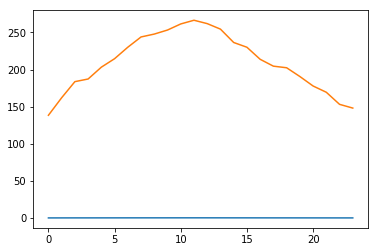

In [32]:
np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
predicted_rps = np.array(squashed_labels_to_labels(predicted.reshape(predicted.shape[0])))

print(predicted.reshape(predicted.shape[0]))
np.set_printoptions(formatter={'float': '{: 0.0f}'.format})
print(predicted_rps)

plt.plot(predicted)
plt.plot(predicted_rps)
plt.show()